In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [4]:
(x_train,_),(x_test,_) = fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

print(x_train.shape)
print(x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [5]:
x_train = x_train[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor*tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test+ noise_factor*tf.random.normal(shape=x_test.shape)

In [8]:
x_train_noisy = tf.clip_by_value(x_train_noisy,clip_value_min=0,clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy,clip_value_min=0,clip_value_max=1.)

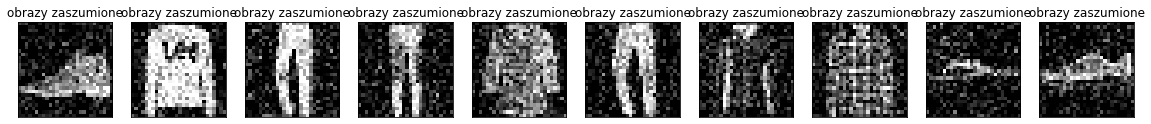

In [9]:
n =10
plt.figure(figsize=(20,2))
for i in range(n):
    ax = plt.subplot(1,n,i+1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    # plt.imshow(x_test_noisy[i])
    plt.title("obrazy zaszumione")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [17]:
#splotowy enkoder odszumiający
class Denoise(Model):
    def __init__(self):
        super(Denoise,self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28,28,1)),
            layers.Conv2D(16,(3,3),activation='relu',padding='same',strides=2),
            layers.Conv2D(8,(3,3),activation='relu',padding='same',strides=2)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8,kernel_size=3,activation='relu',padding='same',strides=2),
            layers.Conv2DTranspose(16,kernel_size=3,activation='relu',padding='same',strides=2),
            layers.Conv2D(1,kernel_size=(3,3),activation='sigmoid',padding ='same')
        ])
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
autoenkoder = Denoise()

autoenkoder.compile(optimizer='adam',loss=losses.MeanSquaredError())

autoenkoder.fit(x_train_noisy,x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy,x_test))

Epoch 1/10
1875/1875 [==============================] - 54s 28ms/step - loss: 0.0173 - val_loss: 0.0095
Epoch 2/10
1223/1875 [==================>...........] - ETA: 17s - loss: 0.0090

In [ ]:
autoenkoder.encoder.summary()

In [ ]:
autoenkoder.decoder.summary()

In [14]:
#testowanie autoenkodera na zbiorze testowym
encoded_imgs = autoenkoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoenkoder.decoder(encoded_imgs).numpy()

TypeError: TypeError: Invalid shape (28, 28, 16) for image data

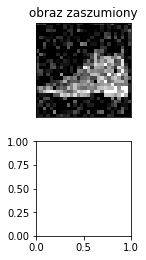

In [15]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.title('obraz zaszumiony')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.title('zdekodowany!')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()